# Form Recognition in Visual NLP

End-to-end form recognition using VisualDocumentNerGeo and GeoRelationExtractor.

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12/"

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Start spark session

In [ ]:
from sparkocr import start
import os
import sys


if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)

spark;

In [3]:
import os
import sys

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
from sparkocr.utils.helpers import cluster
from pyspark.sql.functions import udf, col, size, explode
from pyspark.sql.types import StructType, StructField, MapType, StringType, BooleanType, StructType

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load image

2024-09-18 14:50:47.888 java[76979:4139826] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.



    Image #0:
    Origin: file:/usr/local/lib/python3.9/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


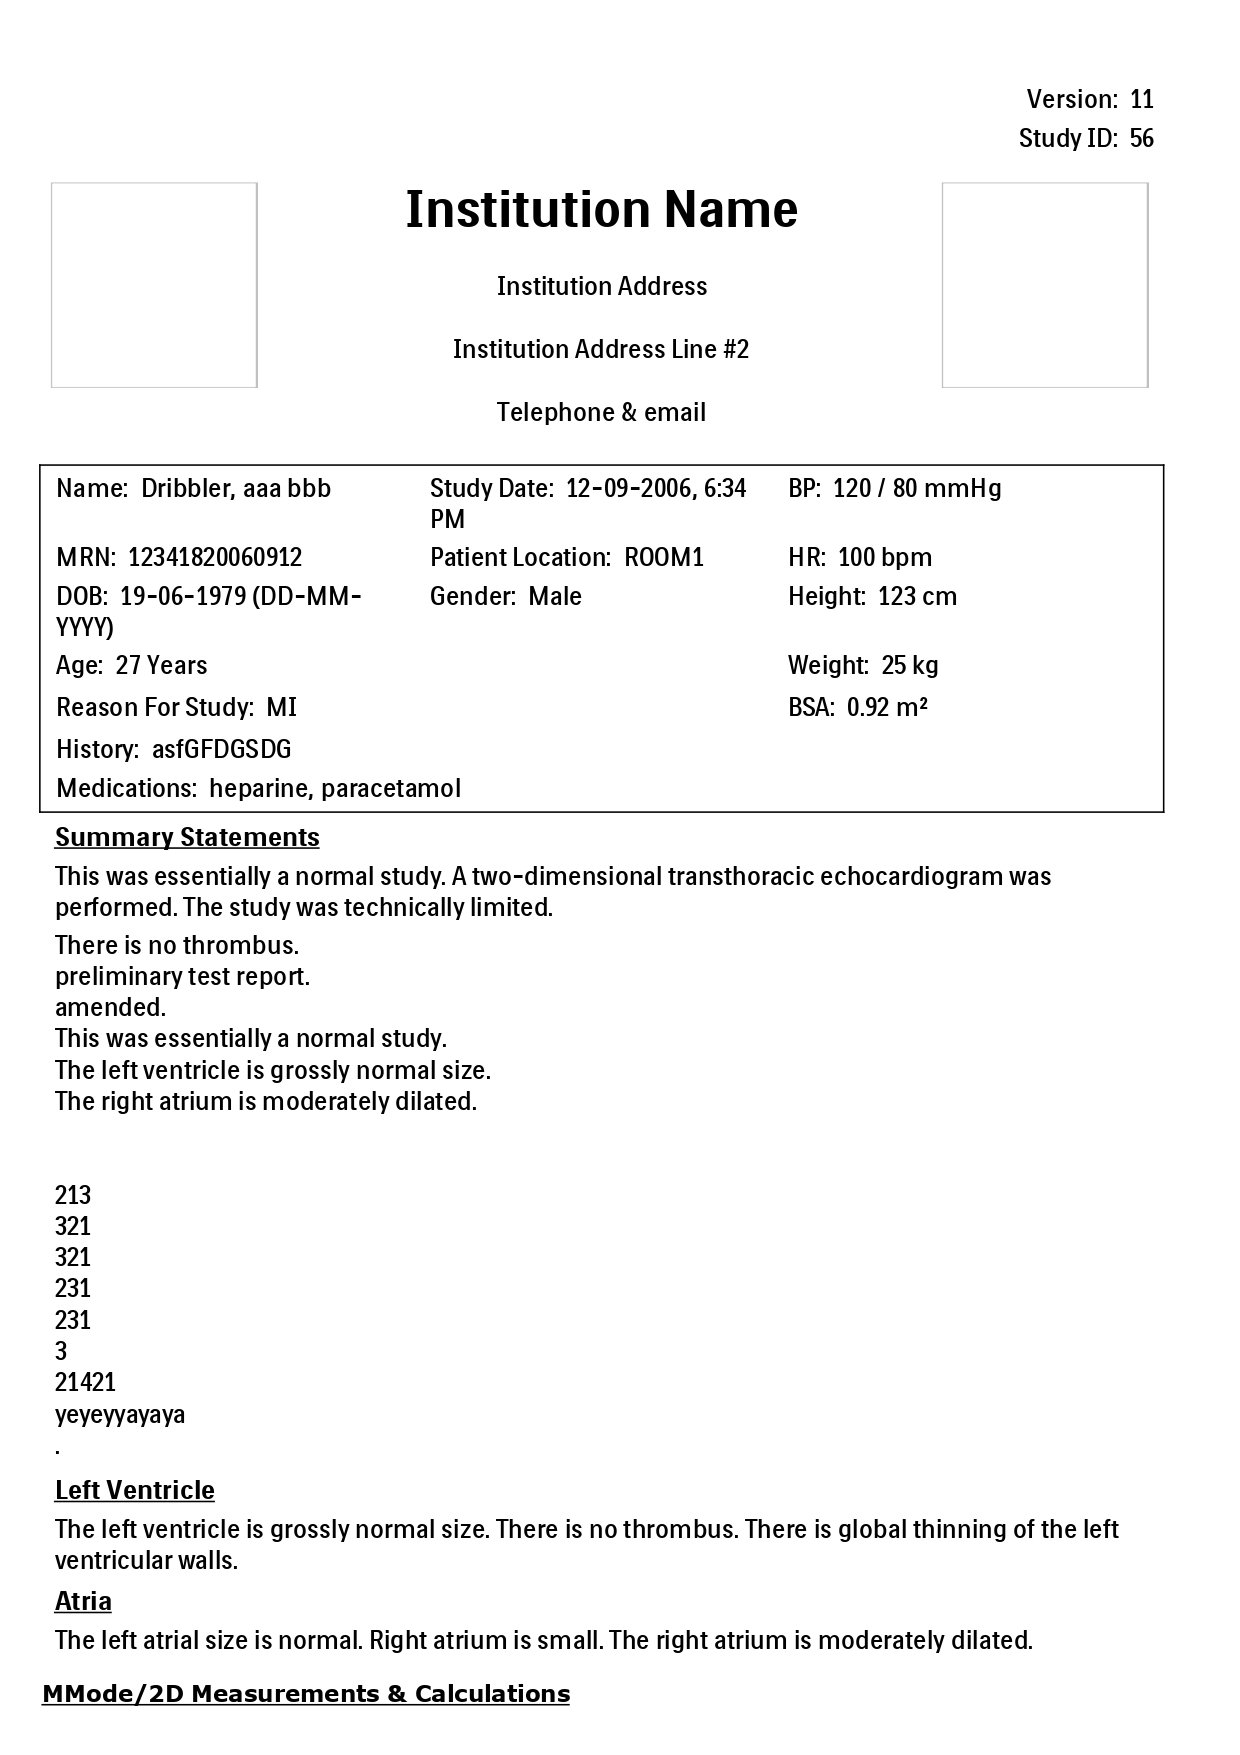

In [4]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
df = spark.read.format("binaryFile").load(test_image_path)
display_images(BinaryToImage().transform(df))

## Define pipeline

In [5]:
binary_to_image = BinaryToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR) 

ocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"]) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)

tokenizer = BrosHocrTokenizer.pretrained("bros_hocr_tokenizer", "en", "clinical/ocr/") \
    .setInputCol("hocr") \
    .setOutputCol("tokens")

hocr_to_features = HocrToFeatures() \
    .setInputCols(["tokens", "image"]) \
    .setOutputCol("features")

ner = VisualDocumentNerGeo().pretrained("visual_ner_geo_v1", "en", "clinical/ocr/") \
    .setInputCols(["features", "tokens", "image"]) \
    .setWhiteList(["other", "i-header", "b-header", "i-question", "b-question", "i-answer", "b-answer"]) \
    .setLabels(["other", "i-header", "b-header", "i-question", "b-question", "i-answer", "b-answer"]) \
    .setOutputCol("entities")

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False)

hocr_to_features1 = HocrToFeatures() \
    .setInputCols(["entities", "image"]) \
    .setOutputCol("features1")

re = GeoRelationExtractor.pretrained("visual_re_geo_v2", "en", "clinical/ocr/") \
    .setInputCols(("features1", "entities", "image")) \
    .setLabels(( "other", "b-header", "i-header", "b-question", "b-question", "b-answer", "i-answer")) \
    .setOutputCol("relations") \
    .setOutputFormat(RelationOutputFormat.ANNOTATIONS)

pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr,
    tokenizer,
    hocr_to_features,
    ner,
    hocr_to_features1,
    re,
    draw_annotations
])

bros_hocr_tokenizer download started this may take some time.
Approximate size to download 313.4 KB


24/09/18 14:50:50 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
24/09/18 14:50:50 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


bros_hocr_tokenizer download started this may take some time.
Approximate size to download 313.4 KB
Download done! Loading the resource.
visual_ner_geo_v1 download started this may take some time.


24/09/18 14:50:52 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 1.4 GB


24/09/18 14:50:52 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
24/09/18 14:50:53 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


visual_ner_geo_v1 download started this may take some time.
Approximate size to download 1.4 GB
Download done! Loading the resource.
visual_re_geo_v2 download started this may take some time.


24/09/18 14:50:54 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 1.4 GB


24/09/18 14:50:55 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
24/09/18 14:50:55 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


visual_re_geo_v2 download started this may take some time.
Approximate size to download 1.4 GB
Download done! Loading the resource.


## Run pipeline

In [6]:
result = pipeline.transform(df).cache()

## Display results

In [8]:
result.select(explode("relations").alias("relations"))\
    .select("relations.result", "relations.metadata.text1", "relations.metadata.bbox1", "relations.metadata.text2", "relations.metadata.bbox2") \
    .filter((col("relations.metadata.entity1") == "question") & (col("relations.metadata.entity2") == "answer")) \
    .show(20, False)

+-------------------------------+-----------------+--------------+------------------+--------------+
|result                         |text1            |bbox1         |text2             |bbox2         |
+-------------------------------+-----------------+--------------+------------------+--------------+
|Version: -> 11                 |Version:         |1027 89 90 19 |11                |1132 89 21 19 |
|Study ID: -> 56                |Study ID:        |1020 128 97 23|56                |1131 128 23 19|
|Name: -> Dribbler, aaa bbb     |Name:            |58 478 69 19  |Dribbler, aaa bbb |143 478 187 22|
|Study Date: -> 12-09-2006, 6:34|Study Date:      |431 478 122 23|12-09-2006, 6:34  |568 478 178 22|
|BP: -> 120 / 80 mmHg           |BP:              |790 478 30 19 |120 / 80 mmHg     |835 474 165 31|
|MRN: -> 12341820060912         |MRN:             |58 547 57 19  |12341820060912    |130 547 171 19|
|Patient Location: -> ROOM1     |Patient Location:|432 547 178 19|ROOM1             |626 54


    Image #0:
    Origin: file:/usr/local/lib/python3.9/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


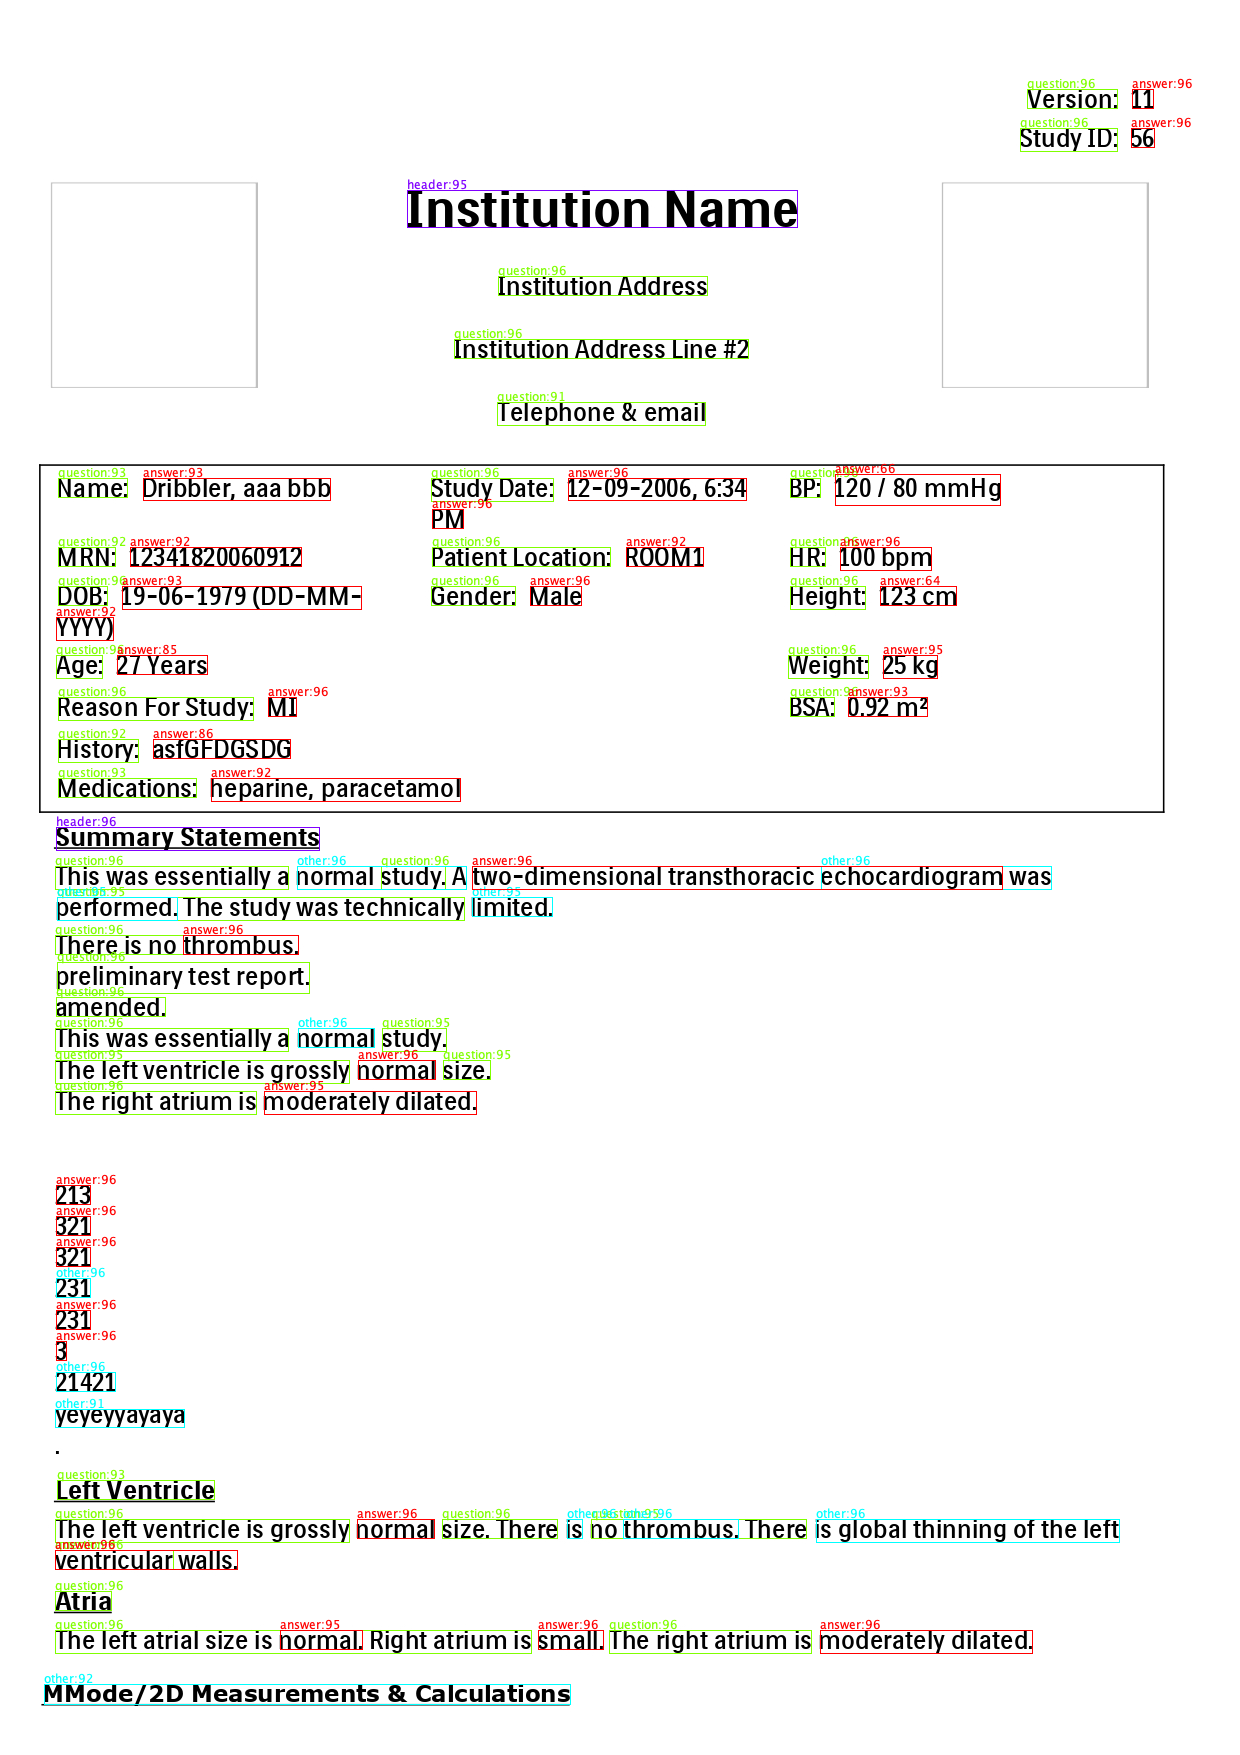

In [9]:
display_images(result, "image_with_annotations")